In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
import statsmodels.api as sm

In [124]:
def gender_from_name(text):
    lower_text = str(text).lower()
    if ('қызы' in lower_text
        or 'кызы' in lower_text
        or 'ова' in lower_text
        or 'овна' in lower_text
       or 'евна' in lower_text
       or 'кизи' in lower_text
       or 'қизи' in lower_text):
        gender = 'female'
    elif ('ұлы' in lower_text
          or 'улы' in lower_text
          or 'ович' in lower_text
         or 'евич' in lower_text):
        gender = 'male'
    else:
        gender = 'unknown'
    return gender

In [125]:
class Project:
    def __init__(self, path):
        self.dataframe = pd.read_csv(path)
        self.gender_defined = False
        self.code_shorten = False
        self.ohe = OneHotEncoder(drop='first', sparse=False)
        self.full_df=None
        self.raw_model=None
        self.neat_model=None
        self.critical_params=None

    def define_gender(self):
        if self.gender_defined:
            print('gender column already created')
            pass
        else:
            self.dataframe['Gender'] = self.dataframe['Name'].apply(gender_from_name)
            print('gender column now created')
            self.gender_defined = True

    def define_code(self):
        if self.code_shorten:
            print('specialization code already shortened')
            pass
        else:
            self.dataframe['SpecCode'] = self.dataframe['Specialization'].apply(lambda x: x.split('-')[0].strip())
            print('specializations encoded')
            self.code_shorten = True
    
    def decode_df(self):
        categories = ['University Code', 'Competition', 'SpecCode', 'Gender']
        transformed_data = self.ohe.fit_transform(self.dataframe[categories])
        self.full_df = pd.DataFrame(transformed_data, columns=self.ohe.get_feature_names_out())
        self.full_df['Score'] = pd.to_numeric(self.dataframe['Score'], errors='coerce') / 140
        self.full_df.dropna(subset=['Score'], inplace=True)
        self.full_df = self.full_df[self.full_df['Gender_unknown']==0].reset_index(drop=True)
        print('data is decoded')

    def split_dataframes(self, random_state=47):
        x = self.full_df.drop(['Gender_male', 'Gender_unknown'], axis=1)
        self.y = self.full_df['Gender_male'].copy()
        for col in x.columns:
            x[col] = x[col].astype(np.float64)
        cols2drop = [key for key,val in x.sum(axis=0).items() if val<x.shape[0]*0.01]
        x.drop(cols2drop, axis=1, inplace=True)
        self.x = x
        self.x_tr, self.x_t, self.y_tr, self.y_t = tts(self.x, self.y, test_size=0.2, stratify=self.y, random_state=random_state)
        print('train test data splitted')
    
    def train_raw_model(self, show_summary=False, show_accuracy=False):
        self.raw_model = sm.Logit(self.y_tr, self.x_tr).fit_regularized(maxiter=1000)
        self.critical_params = [key for key,val in self.raw_model.params.items() if abs(val) >= 10]
        if show_summary:
            print(self.raw_model.summary())
        if show_accuracy:
            y_pred_proba = self.raw_model.predict(self.x_t)
            y_pred = (y_pred_proba>=0.5).astype(int)
            print('test sample')
            print(classification_report(self.y_t, y_pred))
            y_pred_proba = self.raw_model.predict(self.x_tr)
            y_pred = (y_pred_proba>=0.5).astype(int)
            print('train sample')
            print(classification_report(self.y_tr, y_pred))
        print('raw model is trained, critical params are obtained')

    def train_neat_model(self, show_summary=False, show_accuracy=False):
        self.neat_model = sm.Logit(self.y_tr, self.x_tr.drop(self.critical_params, axis=1)).fit(maxiter=1000)
        if show_summary:
            print(self.neat_model.summary())
        if show_accuracy:
            y_pred_proba = self.neat_model.predict(self.x_t.drop(self.critical_params, axis=1))
            y_pred = (y_pred_proba>=0.5).astype(int)
            print('test sample')
            print(classification_report(self.y_t, y_pred))
            y_pred_proba = self.neat_model.predict(self.x_tr.drop(self.critical_params, axis=1))
            y_pred = (y_pred_proba>=0.5).astype(int)
            print('train sample')
            print(classification_report(self.y_tr, y_pred))
        print('neat model is trained')

    def get_dictionaries(self):
        code_df = self.dataframe[['SpecCode', 'Specialization']].drop_duplicates().reset_index(drop=True)
        self.code2specialization = {code_df['SpecCode'][i]: code_df['Specialization'][i] for i in range(len(code_df))}
        self.specialization2code = {val:key for key,val in self.code2specialization.items()}
        self.code2params = {key.split('_')[1]: val for key,val in self.neat_model.params.items() if 'SpecCode' in key}
        self.param2code = {val:key for key,val in self.code2params.items()}
        self.code2pval = {key.split('_')[1]: val for key,val in self.neat_model.pvalues.items() if 'SpecCode' in key}
        self.pval2code = {val:key for key,val in self.code2pval.items()}
        print('dictionaries are created')

    def get_predictor_info(self, top_limit=1, bottom_limit=0.1):
        top_predictors_sig = {self.code2specialization[key]: self.code2params[key] for key in self.code2params.keys()
                              if abs(self.code2params[key])>top_limit
                              and self.code2pval[key] <= 0.05}
        top_predictors_insig = {self.code2specialization[key]: self.code2params[key] for key in self.code2params.keys()
                                if abs(self.code2params[key])>top_limit
                                and self.code2pval[key] > 0.05}
        top_predictors_sig = dict(sorted(top_predictors_sig.items(), reverse=True, key=lambda x: x[1]))
        top_predictors_insig = dict(sorted(top_predictors_insig.items(), reverse=True, key=lambda x: x[1]))
        self.top_predictors_sig = top_predictors_sig
        self.top_predictors_insig = top_predictors_insig
        neutral_predictors_sig = {self.code2specialization[key]: self.code2params[key] for key in self.code2params.keys()
                                  if abs(self.code2params[key])<bottom_limit
                                  and self.code2pval[key] <= 0.05}
        neutral_predictors_insig = {self.code2specialization[key]: self.code2params[key] for key in self.code2params.keys()
                                    if abs(self.code2params[key])<bottom_limit
                                    and self.code2pval[key] > 0.05}
        neutral_predictors_sig = dict(sorted(neutral_predictors_sig.items(), reverse=True, key=lambda x: x[1]))
        neutral_predictors_insig = dict(sorted(neutral_predictors_insig.items(), reverse=True, key=lambda x: x[1]))
        self.neutral_predictors_sig = neutral_predictors_sig
        self.neutral_predictors_insig = neutral_predictors_insig
        print('significant and high importance predictors are obtained')

In [126]:
import pandas as pd

files_years = [('no_gender_2015.csv', 2015), 
               ('no_gender_2016.csv', 2016), 
               ('no_gender_2017.csv', 2017), 
               ('no_gender_2018.csv', 2018), 
               ('no_gender_2019.csv', 2019), 
               ('no_gender_2020.csv', 2020)]

for file, year in files_years:
    project = Project(file)
    project.define_gender()
    project.define_code()
    project.decode_df()
    project.split_dataframes()
files_years = [('no_gender_2015.csv', 2015), 
               ('no_gender_2016.csv', 2016), 
               ('no_gender_2017.csv', 2017), 
               ('no_gender_2018.csv', 2018), 
               ('no_gender_2019.csv', 2019), 
               ('no_gender_2020.csv', 2020)]

dfs = []

for file, year in files_years:
    df = pd.read_csv(file)
    df['Year'] = year
    df['Gender'] = df['Name'].apply(gender_from_name)
    dfs.append(df)

combined_df = pd.concat(dfs)

combined_df.to_csv('no_gender_combined.csv', index=False)

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse

In [127]:
gender_counts = df['Gender'].value_counts()
print(gender_counts)

/var/folders/wk/lknw0tc51f548k5m2ck__hr00000gn/T/ipykernel_8392/1733234155.py:4: DtypeWarning: Columns (0,1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('no_gender_combined.csv')


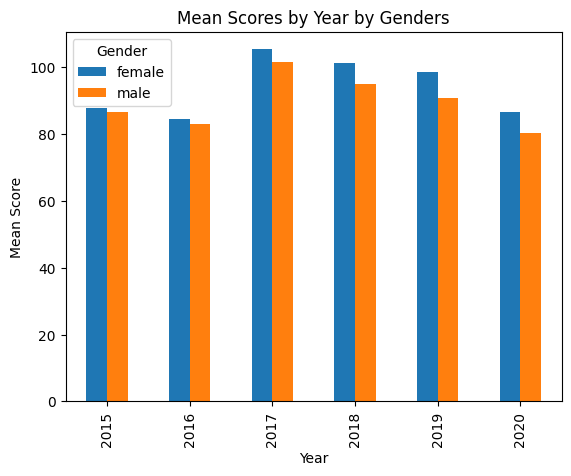

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('no_gender_combined.csv')

df = df[df['Gender'].notna()]

df['Score'] = pd.to_numeric(df['Score'], errors='coerce')

df = df[df['Score'].notna()]
df = df[df['Gender'] != 'unknown']

mean_scores = df.groupby(['Year', 'Gender'])['Score'].mean().unstack()
mean_scores.plot(kind='bar')
plt.title('Mean Scores by Year by Genders')
plt.ylabel('Mean Score')
plt.show()

In [129]:
gender_counts = df['Gender'].value_counts()
gender_counts_df = gender_counts.reset_index()
gender_counts_df.columns = ['Gender', 'Count']
gender_counts_df

,Gender,Count
0,female,105772
1,male,81262


In [130]:
sample = Project('no_gender_2019.csv')

In [131]:
sample.define_gender()

In [132]:
sample.define_code()

In [133]:
sample.decode_df()

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [134]:
sample.split_dataframes()

In [135]:
sample.train_raw_model(show_accuracy=True)

In [136]:
sample.train_neat_model(show_accuracy=True)

In [137]:
sample.critical_params

['University Code_25']

In [138]:
sample.get_dictionaries()

In [139]:
sample.get_predictor_info()

In [140]:
sample.top_predictors_sig

{'B065 - Автотранспортные средства': 2.4798491840023114,
 'B005 - Подготовка учителей физической культуры': 2.0583228145979935,
 'B062 - Электротехника и энергетика': 2.007004865092439,
 'B067 - Воздушный транспорт и технологии': 1.9275451755783872,
 'B064 - Механика и металлообработка': 1.7997725432662184,
 'B058 - Информационная безопасность': 1.7677555414085286,
 'B071 - Горное дело и добыча полезных ископаемых': 1.7442187461255436,
 'B063 - Электротехника и автоматизация': 1.6331081402085086,
 'B074 - Градостроительство, строительные работы и гражданское строительство': 1.4434285610031063,
 'B057 - Информационные технологии': 1.1448682331710638,
 'B059 - Коммуникации и коммуникационные технологии': 1.1020727144572628,
 'B068 - Производство продуктов питания': -1.0250859746842513,
 'B012 - Подготовка учителей химии': -1.157812945981258,
 'B013 - Подготовка учителей биологии': -1.5098600219555396,
 'B018 - Подготовка учителей иностранного языка': -1.7064577976704285,
 'B017 - Подгото

In [141]:
sample.top_predictors_insig

{}

In [142]:
sample.neutral_predictors_sig

{}

In [143]:
sample.neutral_predictors_insig

{'B072 - Технология фармацевтического производства': -0.051676115582319236,
 'B086 - Общая медицина': -0.07351074388540517}

In [144]:
project2018 = Project('no_gender_2018.csv')
project2018.define_gender()
project2018.define_code()
project2018.decode_df()
project2018.split_dataframes()
project2018.train_raw_model()
project2018.train_neat_model()
project2018.get_dictionaries()
project2018.get_predictor_info()
project2018.top_predictors_sig

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'5B071300 - Көлік, көліктік техника және технологиялар': 2.269541699259204,
 '5B071800 - Электр энергетикасы': 2.2151927220324112,
 '5B071200 - Машина жасау': 2.1654554695344457,
 '5B072400 - Технологиялық машиналар және жабдықтар (сала бойынша)': 1.8340268308028604,
 '5B010800 - Денешынықтыру және спорт': 1.6802909482669546,
 '5B071700 - Жылу энергетикасы': 1.4720082822758818,
 '5B070200 - Автоматтандыру және басқару': 1.401218815981228,
 '5B070800 - Мұнай газ ісі': 1.330579231162991,
 '5B070400 - Есептеу техникасы және бағдарламалық қамтамасыз ету': 1.2364437266090267,
 '5B060700 - Биология': -1.013870661347679,
 '5B072800 - Қайта өңдеу өндірістерінің технологиясы (сала бойынша)': -1.06916182726644,
 '5B011300 - Биология': -1.3302945089475855,
 '5B011700 - Қазақ тілі мен әдебиеті': -1.5826099019842061,
 '5B011900 - Шетел тілі: екі шетел тілі (ағылшын тілі)': -1.9025096801223145,
 '5B010500 - Дефектология': -2.9747666140028035}

In [145]:
project2020 = Project('no_gender_2020.csv')
project2020.define_gender()
project2020.define_code()
project2020.decode_df()
project2020.split_dataframes()
project2020.train_raw_model()
project2020.train_neat_model()
project2020.get_dictionaries()
project2020.get_predictor_info()
project2020.top_predictors_sig

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'B065 - Автотранспортные средства': 2.457292526476262,
 'B062 - Электротехника и энергетика': 2.408522534733216,
 'B063 - Электротехника и автоматизация': 2.2302456667408523,
 'B064 - Механика и металлообработка': 2.052196223341347,
 'B071 - Горное дело и добыча полезных ископаемых': 1.811622507172278,
 'B058 - Информационная безопасность': 1.633007698931467,
 'B074 - Градостроительство, строительные работы и гражданское строительство': 1.3053261828917224,
 'B067 - Воздушный транспорт и технологии': 1.2774252896753884,
 'B057 - Информационные технологии': 1.2330771722754856,
 'B059 - Коммуникации и коммуникационные технологии': 1.1613274582001683,
 'B012 - Подготовка учителей химии': -1.1111380130199309,
 'B016 - Подготовка учителей казахского языка и литературы': -1.4989876711415004,
 'B017 - Подготовка учителей русского языка и литературы': -1.6911591685436547,
 'B018 - Подготовка учителей иностранного языка': -1.829029675285039,
 'B013 - Подготовка учителей биологии': -2.0792245415

In [146]:
project2020.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                30316
Model:                          Logit   Df Residuals:                    30249
Method:                           MLE   Df Model:                           66
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1991
Time:                        08:36:45   Log-Likelihood:                -16465.
converged:                       True   LL-Null:                       -20558.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_2            -0.0188      0.074     -0.255      0.799      -0.163       0.125
University Code_5            -0.2614      0.087     -3.000      0.003      -0.432      -0.091
University Code_7            -0.4758      0.075     -6.343      0.000      -0.623      -0.329
University Code_11           -0.2827      0.134     -2.113      0.035      -0.545      -0.020
University Code_12           -0.0261      0.117     -0.223      0.823      -0.255       0.203
University Code_13           -0.1426      0.062     -2.292      0.022      -0.265      -0.021
University Code_16           -0.1400      0.145     -0.966      0.334      -0.424       0.144
University Code_19           -0.2092      0.123     -1.707      0.088      -0.449       0.031
University Code_21           -0.2209      0.130     -1.705      0.088      -0.475       0.033
University Code_22           -0.0485      0.092     -0.526      0.599      -0.229       0.132
University Code_23           -0.3872      0.167     -2.312      0.021      -0.715      -0.059
University Code_24           -0.0452      0.097     -0.465      0.642      -0.236       0.145
University Code_26           -0.2998      0.110     -2.720      0.007      -0.516      -0.084
University Code_27           -0.1513      0.076     -1.982      0.047      -0.301      -0.002
University Code_29           -0.1177      0.070     -1.681      0.093      -0.255       0.019
University Code_30            0.0909      0.134      0.676      0.499      -0.173       0.354
University Code_31           -0.4050      0.100     -4.065      0.000      -0.600      -0.210
University Code_32           -0.3031      0.089     -3.407      0.001      -0.477      -0.129
University Code_34           -0.2557      0.130     -1.963      0.050      -0.511      -0.000
University Code_35           -0.2624      0.124     -2.120      0.034      -0.505      -0.020
University Code_37           -0.3468      0.116     -2.978      0.003      -0.575      -0.119
University Code_38           -0.0871      0.101     -0.862      0.389      -0.285       0.111
University Code_40            0.1508      0.101      1.494      0.135      -0.047       0.349
University Code_42           -0.4663      0.131     -3.547      0.000      -0.724      -0.209
University Code_43           -0.2458      0.112     -2.193      0.028      -0.466      -0.026
University Code_45           -0.1789      0.069     -2.604      0.009      -0.313      -0.044
University Code_53           -0.7497      0.095     -7.879      0.000      -0.936      -0.563
University Code_57           -0.3172      0.081     -3.896      0.000      -0.477      -0.158
University Code_302           0.0471      0.088      0.534      0.593      -0.126       0.220
University Code_501          -0.0074      0.106     -0.070      0.944      -0.215       0.200
Competition_village quota    -0.1942      0.045     -4.333      0.000      -0.282      -0.106
SpecCode_B003                -3.3948      0.3

In [147]:
project2017 = Project('no_gender_2017.csv')
project2017.define_gender()
project2017.define_code()
project2017.decode_df()
project2017.split_dataframes()
project2017.train_raw_model()
project2017.train_neat_model()
project2017.get_dictionaries()
project2017.get_predictor_info(bottom_limit=0.5)
project2017.top_predictors_sig

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'5B071800 - Электр энергетикасы': 2.1173284776168595,
 '5B071200 - Машина жасау': 1.9228854033612068,
 '5B071700 - Жылу энергетикасы': 1.6067427946110449,
 '5B071300 - Көлік, көліктік техника және технологиялар': 1.507447785208748,
 '5B072400 - Технологиялық машиналар және жабдықтар (сала бойынша)': 1.4819450730928063,
 '5B070800 - Мұнай газ ісі': 1.3694882648761006,
 '5B070900 - Металлургия': 1.3569035667193425,
 '5B070700 - Тау-кен ісі': 1.2964521800585511,
 '5B070200 - Автоматтандыру және басқару': 1.2869192897639083,
 '5B010800 - Денешынықтыру және спорт': 1.2316684833314788,
 '5B072900 - Құрылыс': 1.1869387122416473,
 '5B070400 - Есептеу техникасы және бағдарламалық қамтамасыз ету': 1.1689458626150009,
 '5B060700 - Биология': -1.0383221089581947,
 '5B072700 - Азық–түлік өнімдерінің технологиясы': -1.194195222708733,
 '5B070100 - Биотехнология': -1.285046717998351,
 '5B011700 - Қазақ тілі мен әдебиеті': -1.3037053209531482,
 '5B011200 - Химия': -1.3668029267917896,
 '5B011300 - Би

In [148]:
project2017.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                20349
Model:                          Logit   Df Residuals:                    20289
Method:                           MLE   Df Model:                           59
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1493
Time:                        08:36:52   Log-Likelihood:                -11850.
converged:                       True   LL-Null:                       -13929.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_2.0           0.2632      0.086      3.048      0.002       0.094       0.432
University Code_4.0          -0.2843      0.162     -1.755      0.079      -0.602       0.033
University Code_5.0           0.0355      0.120      0.296      0.767      -0.199       0.271
University Code_7.0          -0.3859      0.121     -3.200      0.001      -0.622      -0.150
University Code_12.0          0.3944      0.123      3.213      0.001       0.154       0.635
University Code_13.0          0.2739      0.066      4.138      0.000       0.144       0.404
University Code_19.0          1.1721      0.166      7.051      0.000       0.846       1.498
University Code_20.0          1.1242      0.201      5.581      0.000       0.729       1.519
University Code_21.0         -0.1343      0.158     -0.848      0.396      -0.445       0.176
University Code_22.0          1.2731      0.157      8.101      0.000       0.965       1.581
University Code_24.0          0.1308      0.088      1.480      0.139      -0.042       0.304
University Code_26.0         -0.2440      0.104     -2.336      0.020      -0.449      -0.039
University Code_27.0         -0.0224      0.059     -0.378      0.706      -0.139       0.094
University Code_29.0          0.6057      0.094      6.453      0.000       0.422       0.790
University Code_30.0         -0.0143      0.120     -0.119      0.905      -0.250       0.222
University Code_31.0         -0.3768      0.149     -2.527      0.011      -0.669      -0.085
University Code_32.0          0.4690      0.109      4.309      0.000       0.256       0.682
University Code_38.0          0.4336      0.116      3.727      0.000       0.206       0.662
University Code_41.0         -0.3563      0.140     -2.552      0.011      -0.630      -0.083
University Code_42.0         -0.0075      0.131     -0.057      0.955      -0.264       0.249
University Code_45.0          0.1464      0.077      1.900      0.057      -0.005       0.297
University Code_53.0         -0.1340      0.122     -1.098      0.272      -0.373       0.105
University Code_57.0          0.9404      0.123      7.628      0.000       0.699       1.182
University Code_157.0         1.4407      0.150      9.631      0.000       1.147       1.734
University Code_196.0        -0.2277      0.138     -1.653      0.098      -0.498       0.042
University Code_302.0         0.3026      0.126      2.409      0.016       0.056       0.549
University Code_501.0         0.4528      0.140      3.242      0.001       0.179       0.727
University Code_515.0        -0.5216      0.181     -2.889      0.004      -0.876      -0.168
Competition_village quota    -0.2385      0.043     -5.604      0.000      -0.322      -0.155
SpecCode_5B010500            -2.0005      0.270     -7.418      0.000      -2.529      -1.472
SpecCode_5B010800             1.2317      0.139      8.880      0.000       0.960       1.504
SpecCode_5B010900             0.0956      0.1

In [149]:
project2017.neutral_predictors_sig

{'5B130100 - Жалпы медицина': 0.16759091250582553,
 '5B072600 - Жеңіл өнеркәсіп бұйымдарының технологиясы және құрастырылуы': -0.3591497877234078}

In [150]:
project2015 = Project('no_gender_2015.csv')
project2015.define_gender()
project2015.define_code()
project2015.decode_df()
project2015.split_dataframes()
project2015.train_raw_model()
project2015.train_neat_model()
project2015.get_dictionaries()
project2015.get_predictor_info()
project2015.top_predictors_sig

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'5B071800 - Электроэнергетика': 2.2103573233010243,
 '5B080600 - Аграрная техника и технология': 1.9034955145916872,
 '5B071300 - Транспорт, транспортная техника и технологии': 1.8711893743623034,
 '5B072400 - Технологические машины и оборудование (по отраслям)': 1.8508249566345367,
 '5B071200 - Машиностроение': 1.847503837708284,
 '5B072900 - Строительство': 1.6426411871888786,
 '5B070800 - Нефтегазовое дело': 1.5432138869305085,
 '5B070900 - Металлургия': 1.416956240517642,
 '5B070700 - Горное дело': 1.368408516010633,
 '5B010800 - Физическая культура и спорт': 1.3546257014011105,
 '5B071700 - Теплоэнергетика': 1.225864680782065,
 '5B070400 - Вычислительная техника и программное обеспечение': 1.2234628382553743,
 '5B070200 - Автоматизация и управление': 1.1591316598705392,
 '5B070600 - Геология и разведка месторождений полезных ископаемых': 1.137916213293991,
 '5B011700 - Казахский язык и литература': -1.314560977775378,
 '5B012300 - Социальная педагогика и самопознание': -1.5143480

In [151]:
project2016 = Project('no_gender_2016.csv')
project2016.define_gender()
project2016.define_code()
project2016.decode_df()
project2016.split_dataframes()
project2016.train_raw_model()
project2016.train_neat_model()
project2016.get_dictionaries()
project2016.get_predictor_info()
project2016.top_predictors_sig

/Users/user/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'5B071800 - Электр энергетикасы': 2.369048168259483,
 '5B071200 - Машина жасау': 2.1886084316525225,
 '5B071300 - Көлік, көліктік техника және технологиялар': 1.9662966736970646,
 '5B072400 - Технологиялық машиналар және жабдықтар (сала бойынша)': 1.6044066763468081,
 '5B072900 - Құрылыс': 1.5238324624049981,
 '5B070200 - Автоматтандыру және басқару': 1.3860010423297604,
 '5B080600 - Аграрлық техника және технология': 1.2538840484776939,
 '5B070800 - Мұнай газ ісі': 1.2274538481292072,
 '5B071700 - Жылу энергетикасы': 1.2186804843339643,
 '5B010800 - Денешынықтыру және спорт': 1.206975819735351,
 '5B070700 - Тау-кен ісі': 1.1421905544586224,
 '5B070900 - Металлургия': 1.0769605268400226,
 '5B070400 - Есептеу техникасы және бағдарламалық қамтамасыз ету': 1.0049579460082663,
 '5B072700 - Азық–түлік өнімдерінің технологиясы': -1.0272802249110866,
 '5B011900 - Шетел тілі: екі шетел тілі (ағылшын тілі)': -1.5620808808694935,
 '5B011700 - Қазақ тілі мен әдебиеті': -1.5827042264904239,
 '5B0

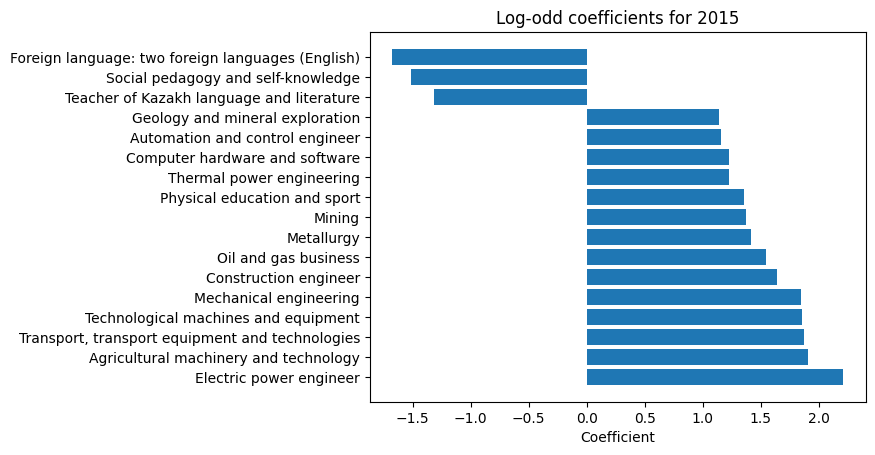

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline

data = {
    'Electric power engineer': 2.2103573233010243,
 'Agricultural machinery and technology': 1.9034955145916872,
 'Transport, transport equipment and technologies': 1.8711893743623034,
 'Technological machines and equipment': 1.8508249566345367,
 'Mechanical engineering': 1.847503837708284,
 'Construction engineer': 1.6426411871888786,
 'Oil and gas business': 1.5432138869305085,
 'Metallurgy': 1.416956240517642,
 'Mining': 1.368408516010633,
 'Physical education and sport': 1.3546257014011105,
 'Thermal power engineering': 1.225864680782065,
 'Computer hardware and software': 1.2234628382553743,
 'Automation and control engineer': 1.1591316598705392,
 'Geology and mineral exploration': 1.137916213293991,
 'Teacher of Kazakh language and literature': -1.314560977775378,
 'Social pedagogy and self-knowledge': -1.514348006108045,
 'Foreign language: two foreign languages ​​(English)': -1.6751301471670867}


plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Coefficient')
plt.title('Log-odd coefficients for 2015')
plt.show()

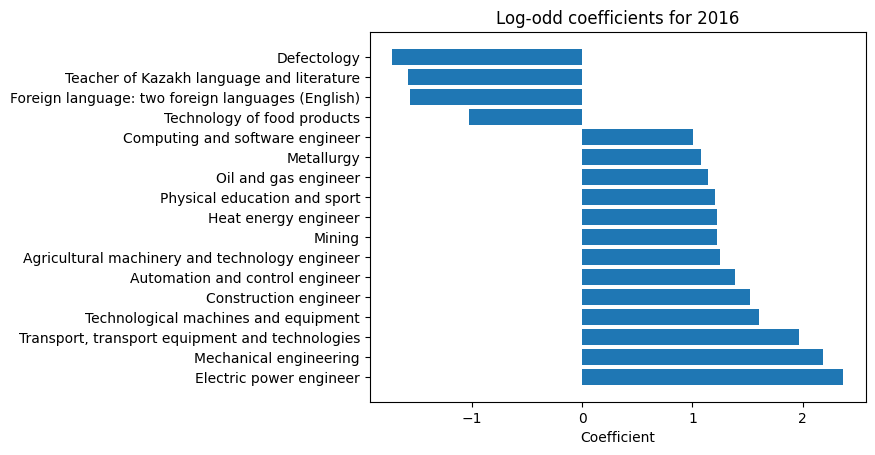

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

data = {
    'Electric power engineer': 2.369048168259483,
 'Mechanical engineering': 2.1886084316525225,
 'Transport, transport equipment and technologies': 1.9662966736970646,
 'Technological machines and equipment': 1.6044066763468081,
 'Construction engineer': 1.5238324624049981,
 'Automation and control engineer': 1.3860010423297604,
 'Agricultural machinery and technology engineer': 1.2538840484776939,
 'Mining': 1.2274538481292072,
 'Heat energy engineer': 1.2186804843339643,
 'Physical education and sport': 1.206975819735351,
 'Oil and gas engineer': 1.1421905544586224,
 'Metallurgy': 1.0769605268400226,
 'Computing and software engineer': 1.0049579460082663,
 'Technology of food products': -1.0272802249110866,
 'Foreign language: two foreign languages ​​(English)': -1.5620808808694935,
 'Teacher of Kazakh language and literature': -1.5827042264904239,
 'Defectology': -1.7218701980013151}


plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Coefficient')
plt.title('Log-odd coefficients for 2016')
plt.show()

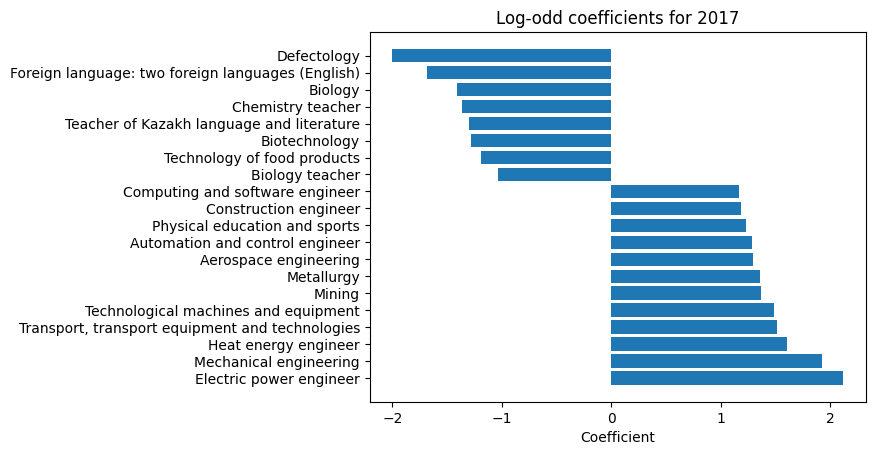

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline

data = {'Electric power engineer': 2.1173284776168595,
 'Mechanical engineering': 1.9228854033612068,
 'Heat energy engineer': 1.6067427946110449,
 'Transport, transport equipment and technologies': 1.507447785208748,
 'Technological machines and equipment': 1.4819450730928063,
 'Mining': 1.3694882648761006,
 'Metallurgy': 1.3569035667193425,
 'Aerospace engineering': 1.2964521800585511,
 'Automation and control engineer': 1.2869192897639083,
 'Physical education and sports': 1.2316684833314788,
 'Construction engineer': 1.1869387122416473,
 'Computing and software engineer': 1.1689458626150009,
 'Biology teacher': -1.0383221089581947,
 'Technology of food products': -1.194195222708733,
 'Biotechnology': -1.285046717998351,
 'Teacher of Kazakh language and literature': -1.3037053209531482,
 'Chemistry teacher': -1.3668029267917896,
 'Biology': -1.4112603834386652,
 'Foreign language: two foreign languages ​​(English)': -1.6852416588514567,
 'Defectology': -2.000548250563312}


plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Coefficient')
plt.title('Log-odd coefficients for 2017')
plt.show()

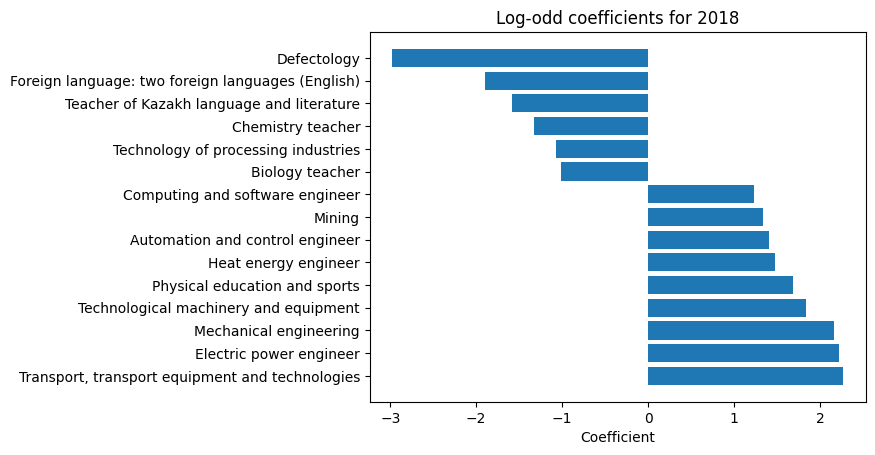

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline

data = {
    'Transport, transport equipment and technologies': 2.269541699259204,
 'Electric power engineer': 2.2151927220324112,
 'Mechanical engineering': 2.1654554695344457,
 'Technological machinery and equipment': 1.8340268308028604,
 'Physical education and sports': 1.6802909482669546,
 'Heat energy engineer': 1.4720082822758818,
 'Automation and control engineer': 1.401218815981228,
 'Mining': 1.330579231162991,
 'Computing and software engineer': 1.2364437266090267,
 'Biology teacher': -1.013870661347679,
 'Technology of processing industries': -1.06916182726644,
 'Chemistry teacher': -1.3302945089475855,
 'Teacher of Kazakh language and literature': -1.5826099019842061,
 'Foreign language: two foreign languages ​​(English)': -1.9025096801223145,
 'Defectology': -2.9747666140028035}


plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Coefficient')
plt.title('Log-odd coefficients for 2018')
plt.show()

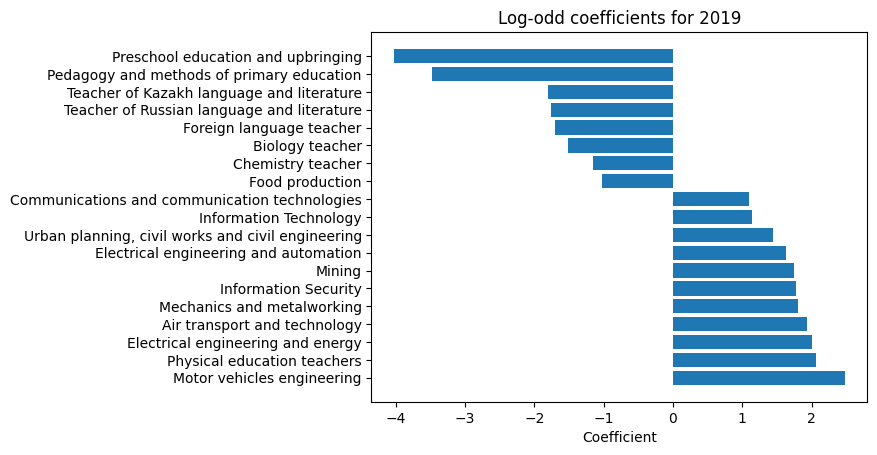

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

data = {
    'Motor vehicles engineering': 2.4798491840023114,
 'Physical education teachers': 2.0583228145979935,
 'Electrical engineering and energy': 2.007004865092439,
 'Air transport and technology': 1.9275451755783872,
 'Mechanics and metalworking': 1.7997725432662184,
 'Information Security': 1.7677555414085286,
 'Mining': 1.7442187461255436,
 'Electrical engineering and automation': 1.6331081402085086,
 'Urban planning, civil works and civil engineering': 1.4434285610031063,
 'Information Technology': 1.1448682331710638,
 'Communications and communication technologies': 1.1020727144572628,
 'Food production': -1.0250859746842513,
 'Chemistry teacher': -1.157812945981258,
 'Biology teacher': -1.5098600219555396,
 'Foreign language teacher': -1.7064577976704285,
 'Teacher of Russian language and literature': -1.754377892181578,
 'Teacher of Kazakh language and literature': -1.805037071377865,
 'Pedagogy and methods of primary education': -3.4692420004011235,
 'Preschool education and upbringing': -4.021996038967778}


plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Coefficient')
plt.title('Log-odd coefficients for 2019')
plt.show()

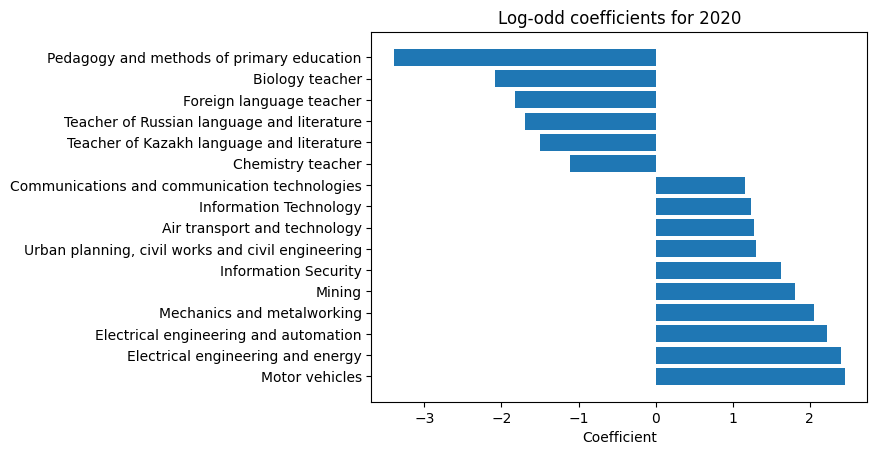

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

data = {
    'Motor vehicles': 2.457292526476262,
 'Electrical engineering and energy': 2.408522534733216,
 'Electrical engineering and automation': 2.2302456667408523,
 'Mechanics and metalworking': 2.052196223341347,
 'Mining': 1.811622507172278,
 'Information Security': 1.633007698931467,
 'Urban planning, civil works and civil engineering': 1.3053261828917224,
 'Air transport and technology': 1.2774252896753884,
 'Information Technology': 1.2330771722754856,
 'Communications and communication technologies': 1.1613274582001683,
 'Chemistry teacher': -1.1111380130199309,
 'Teacher of Kazakh language and literature': -1.4989876711415004,
 'Teacher of Russian language and literature': -1.6911591685436547,
 'Foreign language teacher': -1.829029675285039,
 'Biology teacher': -2.079224541510353,
 'Pedagogy and methods of primary education': -3.3948421680799132}


plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Coefficient')
plt.title('Log-odd coefficients for 2020')
plt.show()

In [158]:
project2015.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                15777
Model:                          Logit   Df Residuals:                    15724
Method:                           MLE   Df Model:                           52
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1463
Time:                        08:37:19   Log-Likelihood:                -9163.4
converged:                       True   LL-Null:                       -10733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_2.0          -0.0217      0.101     -0.215      0.830      -0.220       0.176
University Code_4.0           0.1966      0.156      1.264      0.206      -0.108       0.502
University Code_5.0           0.0103      0.150      0.068      0.946      -0.284       0.305
University Code_7.0          -0.3452      0.166     -2.086      0.037      -0.670      -0.021
University Code_12.0          0.4447      0.149      2.991      0.003       0.153       0.736
University Code_13.0          0.3565      0.071      5.040      0.000       0.218       0.495
University Code_20.0          1.3536      0.234      5.790      0.000       0.895       1.812
University Code_24.0         -0.1152      0.103     -1.115      0.265      -0.318       0.087
University Code_26.0         -0.3760      0.138     -2.735      0.006      -0.646      -0.107
University Code_27.0          0.1543      0.069      2.224      0.026       0.018       0.290
University Code_29.0          0.4989      0.080      6.272      0.000       0.343       0.655
University Code_30.0          0.0771      0.150      0.515      0.607      -0.216       0.371
University Code_32.0          0.1756      0.137      1.284      0.199      -0.092       0.444
University Code_37.0          0.4151      0.144      2.877      0.004       0.132       0.698
University Code_38.0         -0.0110      0.153     -0.072      0.943      -0.312       0.290
University Code_41.0         -0.0383      0.160     -0.240      0.810      -0.351       0.275
University Code_45.0          0.1354      0.092      1.477      0.140      -0.044       0.315
University Code_53.0         -0.4841      0.153     -3.166      0.002      -0.784      -0.184
University Code_57.0          0.9551      0.134      7.122      0.000       0.692       1.218
University Code_157.0         1.8010      0.169     10.679      0.000       1.470       2.132
University Code_302.0         1.0162      0.163      6.236      0.000       0.697       1.336
Competition_village quota    -0.1101      0.045     -2.438      0.015      -0.199      -0.022
SpecCode_5B010800             1.3546      0.151      8.989      0.000       1.059       1.650
SpecCode_5B010900            -0.7759      0.205     -3.788      0.000      -1.177      -0.374
SpecCode_5B011100            -0.0420      0.172     -0.244      0.807      -0.380       0.296
SpecCode_5B011700            -1.3146      0.215     -6.110      0.000      -1.736      -0.893
SpecCode_5B011900            -1.6751      0.182     -9.185      0.000      -2.033      -1.318
SpecCode_5B012000            -0.2364      0.123     -1.924      0.054      -0.477       0.004
SpecCode_5B012300            -1.5143      0.282     -5.374      0.000      -2.067      -0.962
SpecCode_5B060200             0.3823      0.159      2.410      0.016       0.071       0.693
SpecCode_5B070200             1.1591      0.169      6.867      0.000       0.828       1.490
SpecCode_5B070300             0.5995      0.1

In [159]:
project2016.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                21112
Model:                          Logit   Df Residuals:                    21054
Method:                           MLE   Df Model:                           57
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1325
Time:                        08:37:20   Log-Likelihood:                -12504.
converged:                       True   LL-Null:                       -14413.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_002          -0.2284      0.091     -2.513      0.012      -0.407      -0.050
University Code_004          -0.6007      0.156     -3.844      0.000      -0.907      -0.294
University Code_005          -0.2785      0.118     -2.359      0.018      -0.510      -0.047
University Code_007          -0.7901      0.153     -5.171      0.000      -1.090      -0.491
University Code_012           0.3136      0.112      2.808      0.005       0.095       0.533
University Code_013           0.1241      0.063      1.982      0.048       0.001       0.247
University Code_020           1.0020      0.229      4.372      0.000       0.553       1.451
University Code_024          -0.1804      0.092     -1.969      0.049      -0.360      -0.001
University Code_026          -0.8171      0.126     -6.460      0.000      -1.065      -0.569
University Code_027          -0.1877      0.060     -3.154      0.002      -0.304      -0.071
University Code_029           0.3266      0.078      4.190      0.000       0.174       0.479
University Code_030          -0.4404      0.136     -3.234      0.001      -0.707      -0.174
University Code_031          -0.3211      0.125     -2.566      0.010      -0.566      -0.076
University Code_032           0.3280      0.099      3.300      0.001       0.133       0.523
University Code_035          -0.3031      0.144     -2.105      0.035      -0.585      -0.021
University Code_036          -0.0933      0.156     -0.599      0.549      -0.399       0.212
University Code_037          -0.1853      0.146     -1.272      0.203      -0.471       0.100
University Code_038           0.1416      0.108      1.311      0.190      -0.070       0.353
University Code_040          -0.0957      0.143     -0.669      0.504      -0.376       0.185
University Code_041          -0.4423      0.137     -3.224      0.001      -0.711      -0.173
University Code_042          -0.3992      0.130     -3.068      0.002      -0.654      -0.144
University Code_045           0.0823      0.085      0.969      0.333      -0.084       0.249
University Code_053          -0.1791      0.130     -1.373      0.170      -0.435       0.077
University Code_057           0.6483      0.123      5.255      0.000       0.406       0.890
University Code_190           0.9026      0.112      8.057      0.000       0.683       1.122
University Code_302           0.2667      0.131      2.034      0.042       0.010       0.524
University Code_501           0.0394      0.140      0.282      0.778      -0.235       0.314
University Code_517          -0.6241      0.160     -3.912      0.000      -0.937      -0.311
Competition_village quota    -0.1487      0.044     -3.353      0.001      -0.236      -0.062
SpecCode_5B010500            -1.7219      0.248     -6.945      0.000      -2.208      -1.236
SpecCode_5B010800             1.2070      0.158      7.658      0.000       0.898       1.516
SpecCode_5B011700            -1.5827      0.1

In [160]:
project2017.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                20349
Model:                          Logit   Df Residuals:                    20289
Method:                           MLE   Df Model:                           59
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1493
Time:                        08:37:20   Log-Likelihood:                -11850.
converged:                       True   LL-Null:                       -13929.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_2.0           0.2632      0.086      3.048      0.002       0.094       0.432
University Code_4.0          -0.2843      0.162     -1.755      0.079      -0.602       0.033
University Code_5.0           0.0355      0.120      0.296      0.767      -0.199       0.271
University Code_7.0          -0.3859      0.121     -3.200      0.001      -0.622      -0.150
University Code_12.0          0.3944      0.123      3.213      0.001       0.154       0.635
University Code_13.0          0.2739      0.066      4.138      0.000       0.144       0.404
University Code_19.0          1.1721      0.166      7.051      0.000       0.846       1.498
University Code_20.0          1.1242      0.201      5.581      0.000       0.729       1.519
University Code_21.0         -0.1343      0.158     -0.848      0.396      -0.445       0.176
University Code_22.0          1.2731      0.157      8.101      0.000       0.965       1.581
University Code_24.0          0.1308      0.088      1.480      0.139      -0.042       0.304
University Code_26.0         -0.2440      0.104     -2.336      0.020      -0.449      -0.039
University Code_27.0         -0.0224      0.059     -0.378      0.706      -0.139       0.094
University Code_29.0          0.6057      0.094      6.453      0.000       0.422       0.790
University Code_30.0         -0.0143      0.120     -0.119      0.905      -0.250       0.222
University Code_31.0         -0.3768      0.149     -2.527      0.011      -0.669      -0.085
University Code_32.0          0.4690      0.109      4.309      0.000       0.256       0.682
University Code_38.0          0.4336      0.116      3.727      0.000       0.206       0.662
University Code_41.0         -0.3563      0.140     -2.552      0.011      -0.630      -0.083
University Code_42.0         -0.0075      0.131     -0.057      0.955      -0.264       0.249
University Code_45.0          0.1464      0.077      1.900      0.057      -0.005       0.297
University Code_53.0         -0.1340      0.122     -1.098      0.272      -0.373       0.105
University Code_57.0          0.9404      0.123      7.628      0.000       0.699       1.182
University Code_157.0         1.4407      0.150      9.631      0.000       1.147       1.734
University Code_196.0        -0.2277      0.138     -1.653      0.098      -0.498       0.042
University Code_302.0         0.3026      0.126      2.409      0.016       0.056       0.549
University Code_501.0         0.4528      0.140      3.242      0.001       0.179       0.727
University Code_515.0        -0.5216      0.181     -2.889      0.004      -0.876      -0.168
Competition_village quota    -0.2385      0.043     -5.604      0.000      -0.322      -0.155
SpecCode_5B010500            -2.0005      0.270     -7.418      0.000      -2.529      -1.472
SpecCode_5B010800             1.2317      0.139      8.880      0.000       0.960       1.504
SpecCode_5B010900             0.0956      0.1

In [161]:
project2018.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                30795
Model:                          Logit   Df Residuals:                    30740
Method:                           MLE   Df Model:                           54
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1590
Time:                        08:37:21   Log-Likelihood:                -17862.
converged:                       True   LL-Null:                       -21238.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_002           0.3944      0.072      5.471      0.000       0.253       0.536
University Code_005           0.7368      0.096      7.657      0.000       0.548       0.925
University Code_007          -0.4320      0.099     -4.348      0.000      -0.627      -0.237
University Code_012           0.8631      0.112      7.706      0.000       0.644       1.083
University Code_013           0.3031      0.053      5.760      0.000       0.200       0.406
University Code_016          -0.3014      0.134     -2.256      0.024      -0.563      -0.040
University Code_019           1.0379      0.146      7.117      0.000       0.752       1.324
University Code_022           0.6405      0.117      5.487      0.000       0.412       0.869
University Code_024           0.3225      0.081      3.999      0.000       0.164       0.481
University Code_026          -0.3343      0.115     -2.904      0.004      -0.560      -0.109
University Code_027          -0.0408      0.046     -0.878      0.380      -0.132       0.050
University Code_029           0.8194      0.067     12.194      0.000       0.688       0.951
University Code_030           0.0355      0.133      0.266      0.790      -0.226       0.297
University Code_031          -0.3171      0.112     -2.821      0.005      -0.537      -0.097
University Code_032           0.8001      0.089      8.940      0.000       0.625       0.975
University Code_038           0.3958      0.096      4.124      0.000       0.208       0.584
University Code_040           0.0768      0.105      0.733      0.464      -0.129       0.282
University Code_042           0.0189      0.109      0.173      0.862      -0.194       0.232
University Code_043           0.5639      0.119      4.736      0.000       0.331       0.797
University Code_045           0.2344      0.064      3.647      0.000       0.108       0.360
University Code_053          -0.1631      0.097     -1.689      0.091      -0.352       0.026
University Code_057           0.9638      0.092     10.494      0.000       0.784       1.144
University Code_196          -0.6061      0.120     -5.056      0.000      -0.841      -0.371
University Code_302           0.1620      0.083      1.946      0.052      -0.001       0.325
University Code_421           0.2331      0.091      2.565      0.010       0.055       0.411
University Code_501           0.5890      0.109      5.424      0.000       0.376       0.802
Competition_village quota    -0.2184      0.038     -5.704      0.000      -0.293      -0.143
SpecCode_5B010500            -2.9748      0.361     -8.246      0.000      -3.682      -2.268
SpecCode_5B010800             1.6803      0.127     13.192      0.000       1.431       1.930
SpecCode_5B010900            -0.6400      0.132     -4.864      0.000      -0.898      -0.382
SpecCode_5B011300            -1.3303      0.172     -7.755      0.000      -1.667      -0.994
SpecCode_5B011700            -1.5826      0.1

In [162]:
sample.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                31275
Model:                          Logit   Df Residuals:                    31212
Method:                           MLE   Df Model:                           62
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.2009
Time:                        08:37:21   Log-Likelihood:                -17161.
converged:                       True   LL-Null:                       -21476.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_2             0.1299      0.074      1.753      0.080      -0.015       0.275
University Code_5            -0.0906      0.095     -0.951      0.341      -0.277       0.096
University Code_7            -0.3094      0.091     -3.381      0.001      -0.489      -0.130
University Code_11           -0.1640      0.141     -1.160      0.246      -0.441       0.113
University Code_12            0.1146      0.116      0.987      0.323      -0.113       0.342
University Code_13           -0.0459      0.059     -0.782      0.434      -0.161       0.069
University Code_16           -0.1078      0.136     -0.794      0.427      -0.374       0.158
University Code_19            0.5000      0.142      3.517      0.000       0.221       0.779
University Code_22            0.0483      0.111      0.435      0.664      -0.169       0.266
University Code_24            0.3470      0.087      3.990      0.000       0.177       0.517
University Code_26           -0.2879      0.102     -2.830      0.005      -0.487      -0.089
University Code_27           -0.1884      0.050     -3.735      0.000      -0.287      -0.090
University Code_29           -0.1771      0.067     -2.655      0.008      -0.308      -0.046
University Code_31           -0.2831      0.105     -2.695      0.007      -0.489      -0.077
University Code_32           -0.2655      0.087     -3.035      0.002      -0.437      -0.094
University Code_35            0.3011      0.129      2.326      0.020       0.047       0.555
University Code_37            0.4445      0.122      3.646      0.000       0.206       0.683
University Code_38            0.1480      0.105      1.403      0.161      -0.059       0.355
University Code_40            0.3883      0.102      3.818      0.000       0.189       0.588
University Code_42            0.0438      0.109      0.402      0.687      -0.170       0.257
University Code_43           -0.0155      0.125     -0.124      0.902      -0.261       0.230
University Code_45            0.0020      0.066      0.031      0.975      -0.127       0.131
University Code_53           -0.2780      0.099     -2.818      0.005      -0.471      -0.085
University Code_57            0.0937      0.082      1.148      0.251      -0.066       0.254
University Code_196          -0.3580      0.181     -1.977      0.048      -0.713      -0.003
University Code_302           0.3985      0.103      3.853      0.000       0.196       0.601
University Code_501           0.4376      0.109      4.030      0.000       0.225       0.650
Competition_village quota    -0.1296      0.041     -3.197      0.001      -0.209      -0.050
SpecCode_B002                -4.0220      0.412     -9.768      0.000      -4.829      -3.215
SpecCode_B003                -3.4692      0.383     -9.066      0.000      -4.219      -2.719
SpecCode_B005                 2.0583      0.143     14.431      0.000       1.779       2.338
SpecCode_B009                -0.2446      0.1

In [163]:
project2020.neat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Gender_male   No. Observations:                30316
Model:                          Logit   Df Residuals:                    30249
Method:                           MLE   Df Model:                           66
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1991
Time:                        08:37:21   Log-Likelihood:                -16465.
converged:                       True   LL-Null:                       -20558.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
University Code_2            -0.0188      0.074     -0.255      0.799      -0.163       0.125
University Code_5            -0.2614      0.087     -3.000      0.003      -0.432      -0.091
University Code_7            -0.4758      0.075     -6.343      0.000      -0.623      -0.329
University Code_11           -0.2827      0.134     -2.113      0.035      -0.545      -0.020
University Code_12           -0.0261      0.117     -0.223      0.823      -0.255       0.203
University Code_13           -0.1426      0.062     -2.292      0.022      -0.265      -0.021
University Code_16           -0.1400      0.145     -0.966      0.334      -0.424       0.144
University Code_19           -0.2092      0.123     -1.707      0.088      -0.449       0.031
University Code_21           -0.2209      0.130     -1.705      0.088      -0.475       0.033
University Code_22           -0.0485      0.092     -0.526      0.599      -0.229       0.132
University Code_23           -0.3872      0.167     -2.312      0.021      -0.715      -0.059
University Code_24           -0.0452      0.097     -0.465      0.642      -0.236       0.145
University Code_26           -0.2998      0.110     -2.720      0.007      -0.516      -0.084
University Code_27           -0.1513      0.076     -1.982      0.047      -0.301      -0.002
University Code_29           -0.1177      0.070     -1.681      0.093      -0.255       0.019
University Code_30            0.0909      0.134      0.676      0.499      -0.173       0.354
University Code_31           -0.4050      0.100     -4.065      0.000      -0.600      -0.210
University Code_32           -0.3031      0.089     -3.407      0.001      -0.477      -0.129
University Code_34           -0.2557      0.130     -1.963      0.050      -0.511      -0.000
University Code_35           -0.2624      0.124     -2.120      0.034      -0.505      -0.020
University Code_37           -0.3468      0.116     -2.978      0.003      -0.575      -0.119
University Code_38           -0.0871      0.101     -0.862      0.389      -0.285       0.111
University Code_40            0.1508      0.101      1.494      0.135      -0.047       0.349
University Code_42           -0.4663      0.131     -3.547      0.000      -0.724      -0.209
University Code_43           -0.2458      0.112     -2.193      0.028      -0.466      -0.026
University Code_45           -0.1789      0.069     -2.604      0.009      -0.313      -0.044
University Code_53           -0.7497      0.095     -7.879      0.000      -0.936      -0.563
University Code_57           -0.3172      0.081     -3.896      0.000      -0.477      -0.158
University Code_302           0.0471      0.088      0.534      0.593      -0.126       0.220
University Code_501          -0.0074      0.106     -0.070      0.944      -0.215       0.200
Competition_village quota    -0.1942      0.045     -4.333      0.000      -0.282      -0.106
SpecCode_B003                -3.3948      0.3